In [45]:
from scipy import misc
from PIL import Image
from skimage import exposure
from sklearn import svm

import scipy
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import glob
import matplotlib.pyplot as pltss
import cv2
from matplotlib import cm
import pandas as pd
from math import pi, sqrt
import pywt
import os

In [66]:
import os
immatrix=[]
im_unpre = []
folder_path = "C:/Users/yoges/Desktop/mini project code/images"
new_folder_path = "C:/Users/yoges/Desktop/mini project code/gray"
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        image = cv2.imread(os.path.join(folder_path, filename))
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(img_gray) 
    immatrix.append(np.array(equ).flatten())
print(np.shape(equ))

        # Save the grayscale image to a new file
new_filename = filename[:-4] + "_gray.jpg"  # add _gray suffix to filename
cv2.imwrite(os.path.join(new_folder_path, new_filename),gray)

(480, 640)


True

In [64]:
np.shape(np.array(equ).flatten())

(307200,)

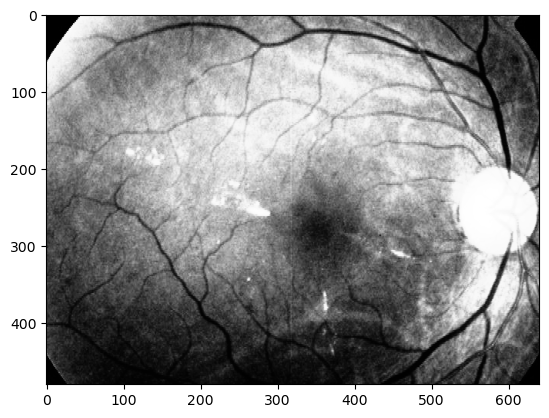

In [67]:
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[1].reshape((480,640)),cmap='gray')
plt.show()

In [68]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((480,640))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())

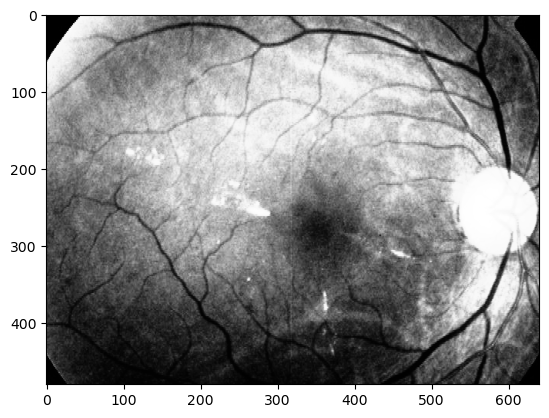

In [70]:
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[1].reshape((480,640)),cmap='gray')
plt.show()

In [71]:
print(len(immatrix))

6


In [72]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()
    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 

In [73]:
def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()

In [74]:
def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels


In [76]:
def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((480,640))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss.append(np.array(equ3).flatten())

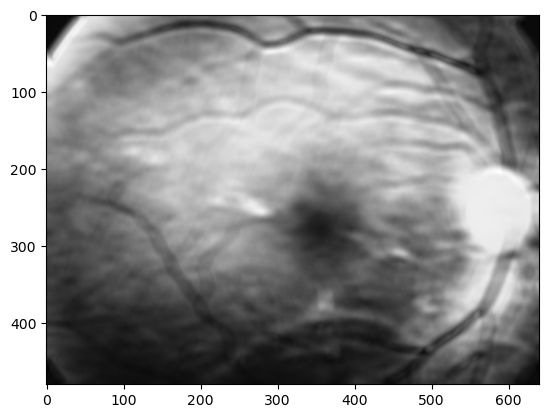

In [79]:
np.shape(imm_gauss)
plt.imshow(imm_gauss[1].reshape((480,640)),cmap='gray')
plt.show()

In [80]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

bank_gf = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((480,640))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())

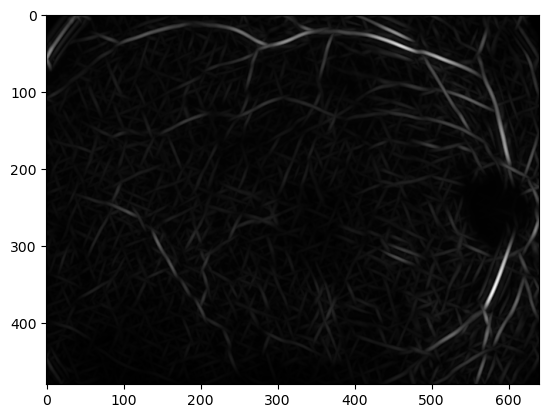

In [82]:
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[1].reshape((480,640)),cmap='gray')
plt.show()

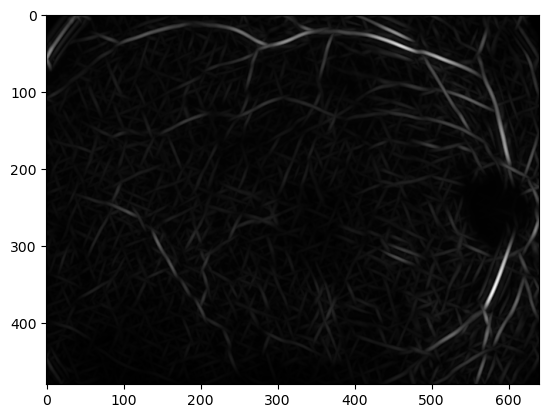

In [83]:
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[1].reshape((480,640)),cmap='gray')
plt.show()

In [84]:
e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,3))
np.shape(e_)

(102400, 3)

In [85]:
img = equ3
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [86]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((480, 640))
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())

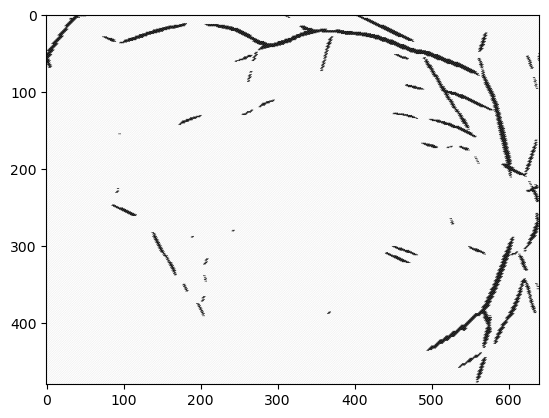

In [87]:
np.shape(imm_kmean)
plt.imshow(imm_kmean[1].reshape((480,640)),cmap="gray")
plt.show()

In [149]:
from sklearn.svm import SVC
clf = SVC()

In [150]:
Y = np.ones(6)

In [151]:
Y[1]=Y[2]=0

In [152]:
clf.fit(imm_kmean, Y)

SVC()

In [153]:
y_pred = clf.predict(imm_kmean)

In [154]:
k = [1,3,4]

In [155]:
k = k-np.ones(len(k))

In [156]:
k

array([0., 2., 3.])

In [157]:
k =[int(x) for x in k]

In [158]:
k

[0, 2, 3]

In [159]:
imm_train = []
y_train = []
k.append(5)
k.append(7)
imm_train.extend(imm_kmean)
y_train.append(Y)

In [164]:
y_train

[array([1., 0., 0., 1., 1., 1.])]

In [166]:
y_pred = clf.predict(imm_kmean)

In [172]:
from sklearn.metrics import accuracy_score

# assume y_true and y_pred are your true and predicted labels, respectively
accuracy = accuracy_score(Y, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.6666666666666666
